In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch,VerticalPitch,FontManager
import seaborn as sns
import os
import requests
from bs4 import BeautifulSoup
import json
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from matplotlib import gridspec
from highlight_text import ax_text,fig_text
import matplotlib
import matplotlib.ticker as ticker


In [111]:
match_id=input('enter_id: ')

enter_id: 4230820


In [112]:
#data of coordinate data

In [116]:
url1=input("enter the url: ")


enter the url: https://1xbet.whoscored.com/Matches/1746305/Live/Italy-Serie-A-2023-2024-Udinese-Inter


In [117]:
res1=requests.get(url1,headers={'User-Agent':"Mozilla/5.0"})

In [118]:
soup1=BeautifulSoup(res1.content,"lxml")
scripts1=soup1.find_all("script")
strings=scripts1[24].string
strings


'\r\n        require.config.params["args"] = {\r\n            matchId:1746305,\r\n            matchCentreData: {"playerIdNameDictionary":{"90000":"Roberto Pereyra","126255":"Lautaro Giannetti","349178":"Nehuén Pérez","349535":"Martín Payero","384577":"Sandi Lovric","68393":"Christian Kabasele","147923":"Walace","494112":"Antonio Tikvic","440029":"Thomas Thiesson Kristensen","99143":"Florian Thauvin","393039":"Lazar Samardzic","408984":"Festy Ebosele","10372":"Daniele Padelli","81109":"Marco Silvestri","244583":"Kingsley Ehizibue","392339":"Maduka Okoye","145940":"Isaac Success","380681":"João Ferreira","360941":"Jaka Bijol","399989":"Oier Zarraga","400609":"Jordan Zemura","239881":"Hassane Kamara","423450":"Kristjan Asllani","299344":"Lautaro Martínez","28421":"Henrikh Mkhitaryan","34693":"Marko Arnautovic","357897":"Carlos Augusto","371027":"Tajon Buchanan","25244":"Alexis Sánchez","259648":"Benjamin Pavard","296322":"Marcus Thuram","349126":"Yann Bisseck","23220":"Matteo Darmian","54

In [119]:
ind_start=strings.index("matchCentreData:")+17
ind_end=strings.index(",\r\n            matchCentreEventTypeJson")
json_data=strings[ind_start:ind_end]
data=json.loads(json_data)
home_id=data["home"]['teamId']
away_id=data["away"]['teamId']
home_name=data['home']['name']
away_name=data['away']['name']
stadium=data['venueName']
date=data['timeStamp'].split(" ")[0]
team_name=pd.DataFrame(data={'teamId':[home_id,away_id],'team':[home_name,away_name]},index=[0,1])
event=data["events"]
player=data["playerIdNameDictionary"]
home_number=data["home"]['formations'][0]["jerseyNumbers"]
home_player_id=data["home"]['formations'][0]["playerIds"]

home_num=pd.DataFrame(home_player_id,index=home_number)

away_number=data["away"]['formations'][0]["jerseyNumbers"]
away_player_id=data["away"]['formations'][0]["playerIds"]
away_num=pd.DataFrame(away_player_id,index=away_number)
away_num.reset_index(inplace=True)

home_num.reset_index(inplace=True)
away_num.columns=["jersy_no","playerId"]
home_num.columns=["jersy_no","playerId"]
merge_jersey=pd.concat([home_num,away_num],axis=0)
merge_jersey['playerId']=merge_jersey['playerId'].apply(lambda x:float(x))
score=data['score']

In [120]:
df1=pd.DataFrame(event)
df10=pd.Series(player)
df10=pd.DataFrame(df10)
df10.reset_index(inplace=True)


df10.columns=["playerId","player_name"]
df10['playerId']=df10['playerId'].apply(lambda x:float(x))
df10=pd.merge(df10,merge_jersey,how="inner",on="playerId")





df1=df1[["id","minute","second","teamId","period","type","outcomeType","playerId","x","y","endX","endY"]]
data1=df1.merge(df10,how="left",on="playerId")



In [121]:
data1

,id,minute,second,teamId,period,type,outcomeType,playerId,x,y,endX,endY,player_name,jersy_no
0,2.669970e+09,0,0.0,86,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,2.669970e+09,0,0.0,75,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,2.669970e+09,0,0.0,86,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}",99143.0,50.0,50.0,30.4,50.4,Florian Thauvin,26.0
3,2.669971e+09,0,5.0,86,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}",147923.0,34.7,51.8,76.5,84.2,Walace,11.0
4,2.669971e+09,0,8.0,86,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 44, 'displayName': 'Aerial'}","{'value': 1, 'displayName': 'Successful'}",440029.0,77.3,82.0,NaN,NaN,Thomas Thiesson Kristensen,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,2.670030e+09,97,59.0,75,"{'value': 2, 'displayName': 'SecondHalf'}","{'value': 30, 'displayName': 'End'}","{'value': 1, 'displayName': 'Successful'}",NaN,0.0,0.0,NaN,NaN,NaN,NaN
1510,2.670030e+09,0,0.0,86,"{'value': 14, 'displayName': 'PostGame'}","{'value': 30, 'displayName': 'End'}","{'value': 1, 'displayName': 'Successful'}",NaN,0.0,0.0,NaN,NaN,NaN,NaN
1511,2.670030e+09,0,0.0,75,"{'value': 14, 'displayName': 'PostGame'}","{'value': 30, 'displayName': 'End'}","{'value': 1, 'displayName': 'Successful'}",NaN,0.0,0.0,NaN,NaN,NaN,NaN
1512,2.669945e+09,0,0.0,75,"{'value': 16, 'displayName': 'PreMatch'}","{'value': 34, 'displayName': 'FormationSet'}","{'value': 1, 'displayName': 'Successful'}",NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [122]:
# data  from fotmob

url = 'https://www.fotmob.com/api/matchDetails?matchId='+match_id
payload = {}
headers={}
response = requests.request("GET",url,headers=headers,data=payload)
data=response.json()
general=pd.DataFrame(data['content']["stats"]['Periods']['All']['stats'][0]['stats'])
data2=pd.DataFrame(data['content']['shotmap']['shots'])

data2=data2[['id',"eventType",'x','y','playerName','min','minAdded','expectedGoals','expectedGoalsOnTarget','shotType','situation','period','teamId',"isOwnGoal"]]
for x,values in data["general"].items():
    if x=="homeTeam":
        team1=pd.DataFrame(values,index=[0])
    elif x=="awayTeam":
        team2=pd.DataFrame(values,index=[1])
    else:
        pass
        
    
teams=pd.concat([team1,team2],axis=0)
home=teams['name'].unique()[0]
away=teams["name"].unique()[1]
data2=pd.merge(data2,teams,how="left",left_on='teamId',right_on='id')
data2=data2.rename(columns={"expectedGoals":"xG","expectedGoalsOnTarget":"xGOT","name":"team"})
data2['minAdded']=data2['minAdded'].fillna(0)
data2['minute']=data2['min']+data2['minAdded']
data2['xG']=data2['xG'].fillna(0)


In [123]:
data2

,id_x,eventType,x,y,playerName,min,minAdded,xG,xGOT,shotType,situation,period,teamId,isOwnGoal,team,id_y,minute
0,2669973979,AttemptSaved,91.900000,22.808153,Denzel Dumfries,5,0.0,0.022192,NaN,LeftFoot,RegularPlay,FirstHalf,8636,False,Inter,8636,5.0
1,2669975337,Miss,93.200000,35.906250,Lautaro Martinez,7,0.0,0.036880,NaN,Header,SetPiece,FirstHalf,8636,False,Inter,8636,7.0
2,2669977091,AttemptSaved,80.795631,36.897500,Federico Dimarco,10,0.0,0.015078,NaN,RightFoot,FromCorner,FirstHalf,8636,False,Inter,8636,10.0
3,2669977111,Miss,86.782353,35.448750,Federico Dimarco,10,0.0,0.019873,NaN,LeftFoot,FromCorner,FirstHalf,8636,False,Inter,8636,10.0
4,2669978611,Miss,80.007282,38.620476,Roberto Pereyra,13,0.0,0.031033,NaN,RightFoot,FastBreak,FirstHalf,8600,False,Udinese,8600,13.0
5,2669979595,AttemptSaved,89.100000,29.043333,Lautaro Martinez,15,0.0,0.093052,NaN,RightFoot,FastBreak,FirstHalf,8636,False,Inter,8636,15.0
6,2669982103,AttemptSaved,83.611165,45.892484,Hakan Calhanoglu,21,0.0,0.022924,0.1048,RightFoot,RegularPlay,FirstHalf,8636,False,Inter,8636,21.0
7,2669983477,Miss,83.160680,21.126624,Hakan Calhanoglu,24,0.0,0.020724,NaN,RightFoot,RegularPlay,FirstHalf,8636,False,Inter,8636,24.0
8,2669987271,AttemptSaved,86.997059,26.343125,Hakan Calhanoglu,30,0.0,0.069671,0.0417,RightFoot,RegularPlay,FirstHalf,8636,False,Inter,8636,30.0
9,2669989273,AttemptSaved,78.430583,18.254013,Lazar Samardzic,33,0.0,0.017840,NaN,LeftFoot,RegularPlay,FirstHalf,8600,False,Udinese,8600,33.0


In [124]:
#for cleaning coordinate data

In [125]:
#data1["period"]=data1["period"].apply(lambda x: str(x))
#data1["period"].str.split(":",n=3,expand=True)[2].str.strip("}")
def clean1(x):
    cleandata=x.apply(lambda x:str(x))
    cleandata=cleandata.str.split(":",n=3,expand=True)[2]
    cleandata=cleandata.str.replace("[^a-zA-z0-9]","",regex=True)
    return cleandata
    

data1["type"]=clean1(data1["type"])
data1["outcomeType"]=clean1(data1["outcomeType"])
data1["period"]=clean1(data1["period"])
data1["teamId"].unique()

array([86, 75], dtype=int64)

In [126]:

data1=pd.merge(data1,team_name,how='left',on='teamId')
data1["jersy_no1"]=data1["jersy_no"].fillna(0.0)
data1["jersy_no1"]=data1["jersy_no1"].apply(lambda x: int(x))
data1['jersy_no1'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 1514 entries, 0 to 1513
Series name: jersy_no1
Non-Null Count  Dtype
--------------  -----
1514 non-null   int64
dtypes: int64(1)
memory usage: 12.0 KB


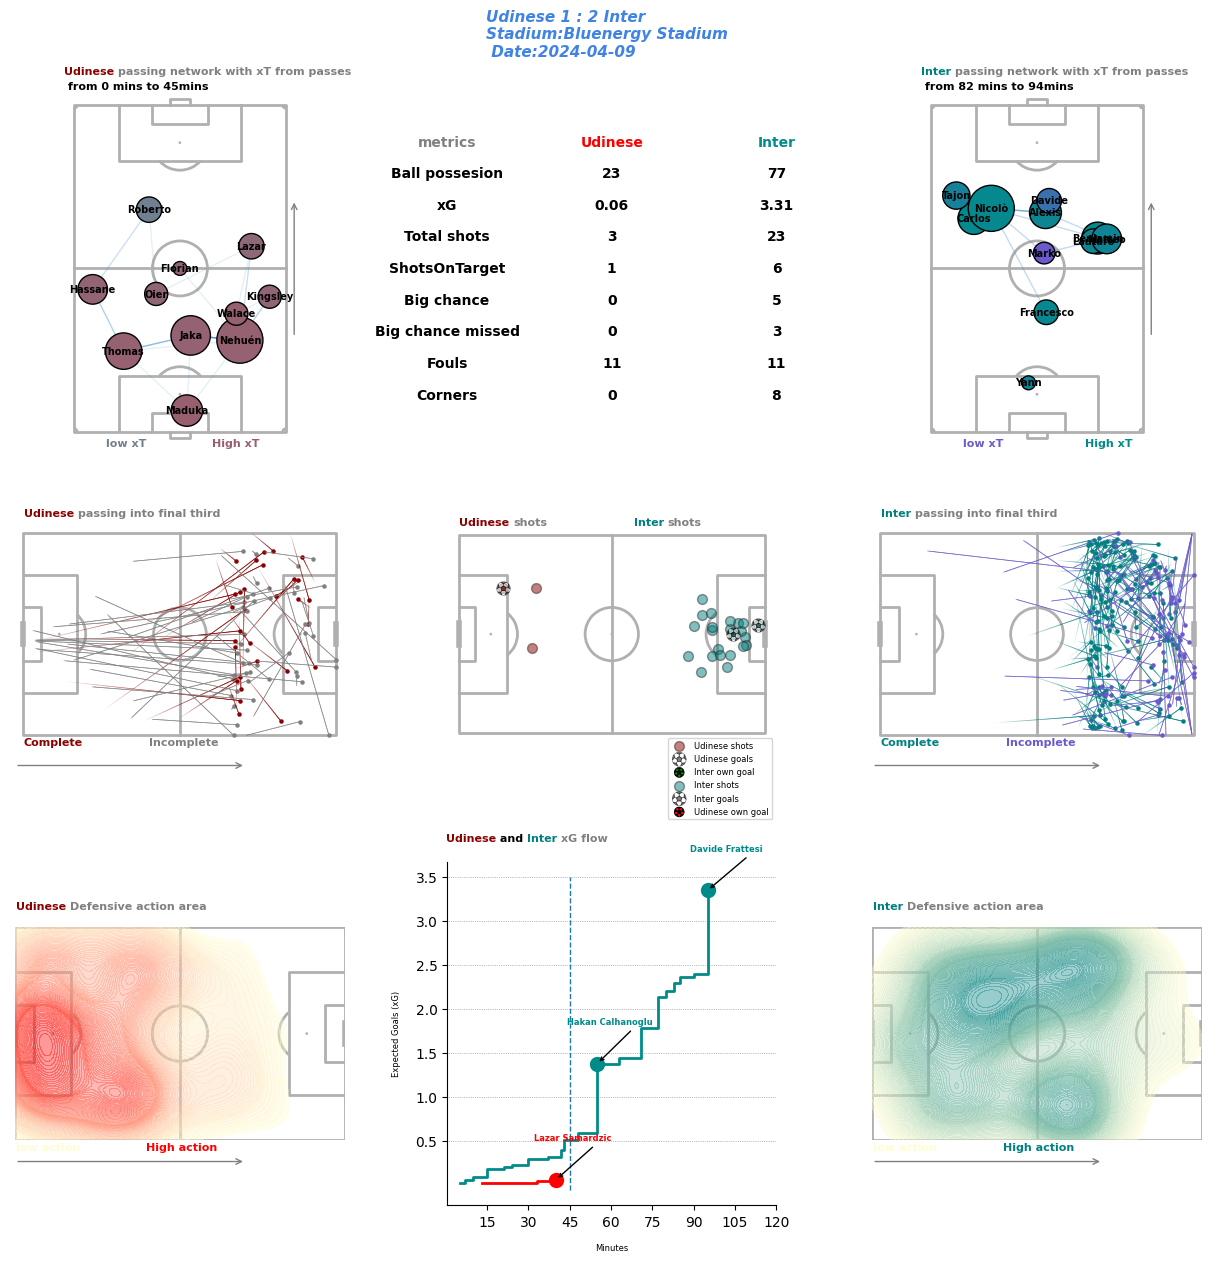

In [140]:
fig=plt.figure(figsize=(12,12),facecolor="white",layout='constrained',dpi=100)
gs=fig.add_gridspec(nrows=3,ncols=3)
fig.text(s=f'{home_name} {score} {away_name}\nStadium:{stadium}\n Date:{date}',x=.4,y=1,size=11,fontweight='bold',
         color='#3F84E5',style='oblique')
#shot plot home & away
ax1=plt.subplot(gs[4])
shot_map(data2,home,away,ax=ax1)
ax_text(x=.1, y=-6,
              s=f'<{home_name}> <shots>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax1, weight = "bold",size=8)
ax_text(x=60, y=-6,
              s=f'<{away_name}> <shots>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
              ax=ax1, weight = "bold",size=8)


#passing network home
ax3=plt.subplot(gs[0])
cmap=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',['#708090','#985F6F'])
#for low to high xt
ax_text(x=85, y=-2,
              s=f'<low xT>                 <High xT>',
              highlight_textprops=[{"color": '#708090'},
                                   {"color": '#985F6F'}],
              ax=ax3, weight = "bold",size=8)
passing_network(data1,home_name,ax=ax3,x=cmap,m=0,n=45)
ax_text(x=105, y=112,
              s=f'<{home_name}> <passing network with xT from passes>\n from 0 mins to 45mins',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax3, weight = "bold",size=8)

#passing networek away
ax4=plt.subplot(gs[2])
cmap1=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',['#6A5ACD',"#008B8B"])
#for low to high xt
ax_text(x=85, y=-2,
        s=f'<low xT>                     <High xT>',
              highlight_textprops=[{"color": '#6A5ACD'},
                                   {"color": "#008B8B"}],
              ax=ax4, weight = "bold",size=8)
passing_network(data1,away_name,ax=ax4,x=cmap1,m=82,n=94)
ax_text(x=105, y=112,
              s=f'<{away_name}> <passing network with xT from passes>\n from 82 mins to 94mins',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
              ax=ax4, weight = "bold",size=8)

# final third passing home
#ax6=plt.subplot(gs[3])
#final_third(data1,home_name,ax=ax6)
#ax_text(x=100, y=105,
             # s=f'<{home}> <passing in final third>',
              #highlight_textprops=[{"color": '#8B0000'},
                                   #{"color": 'grey'}],
              #ax=ax6, weight = "bold",size=6)

# final third passing away
#ax8=plt.subplot(gs[5])
#final_third(data1,away_name,ax=ax8)
#ax_text(x=100, y=105,s=f'<{away}> <passing in final third>',
              #highlight_textprops=[{"color": '#008080'},
                                   #{"color": 'grey'}],
              #ax=ax8, weight = "bold",size=6)
# in to final third home
ax9=plt.subplot(gs[3])
final_into_third(data1,home_name,ax=ax9,x='#8B0000',y='grey')
ax_text(x=.1, y=112,
              s=f'<{home_name}> <passing into final third>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax9, weight = "bold",size=8)
ax_text(x=.1, y=-1,
              s=f'<Complete>                 <Incomplete>',
              highlight_textprops=[{"color":'#8B0000'},
                                   {"color": 'grey'}],
              ax=ax9, weight = "bold",size=8)
# in to final third away
ax11=plt.subplot(gs[5])
final_into_third(data1,away_name,ax=ax11,x='#008080',y='#6A5ACD')
ax_text(x=.1, y=112,
              s=f'<{away_name}> <passing into final third>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
           ax=ax11, weight ="bold",size=8)
ax_text(x=.1, y=-1,
              s=f'<Complete>                 <Incomplete>',
              highlight_textprops=[{"color":'#008080'},
                                   {"color": '#6A5ACD'}],
              ax=ax11, weight = "bold",size=8)
# defensive action home team
ax12=plt.subplot(gs[6])
custommap1=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',["#FFFDD0",'red'])
defensive_action(data1,home_name,ax=ax12,x=custommap1)
ax_text(x=.1, y=112,
              s=f'<{home_name}> <Defensive action area>',
              highlight_textprops=[{"color": '#8B0000'},
                                   {"color": 'grey'}],
              ax=ax12, weight = "bold",size=8)
ax_text(x=.1, y=-1,
              s=f'<low action>                 <High action>',
              highlight_textprops=[{"color":"#FFFDD0"},
                                   {"color": 'red'}],
              ax=ax12, weight = "bold",size=8)
# defensive action away
ax12=plt.subplot(gs[8])
custommap2=matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap',["#FFFDD0","#008080"])
defensive_action(data1,away_name,ax=ax12,x=custommap2)
ax_text(x=.1, y=112,
              s=f'<{away_name}> <Defensive action area>',
              highlight_textprops=[{"color": '#008080'},
                                   {"color": 'grey'}],
              ax=ax12, weight = "bold",size=8)
ax_text(x=.1, y=-1,
              s=f'<low action>                 <High action>',
              highlight_textprops=[{"color":"#FFFDD0"},
                                   {"color": '#008080'}],
              ax=ax12, weight = "bold",size=8)
#xg flow
ax13=plt.subplot(gs[7])
xg_flow(data2,home,away,ax=ax13)
ax_text(x=.1, y=4,
              s=f'<{home_name}> and <{away_name}> <xG flow>',
              highlight_textprops=[{"color": '#8B0000'},{'color':'#008080'},
                                   {"color": 'grey'}],
              ax=ax13, weight = "bold",size=8)


ax14=plt.subplot(gs[1])
stats(general,ax=ax14)

In [ ]:
#shot function

In [127]:
def shot_map(df,home,away,ax):
    home_df=df.loc[df['team']==home].copy()
    away_df=df.loc[df['team']==away].copy()
    home_goals = home_df[(home_df['eventType'] == 'Goal')&(home_df['isOwnGoal']==False)].copy()
    away_goals = away_df[(away_df['eventType'] == 'Goal')&(away_df['isOwnGoal']==False)].copy()
    pitch=Pitch(pitch_type='uefa',pitch_color="white")
    pitch.draw(ax=ax)
    ax.invert_yaxis()
    # Home team shots and goals
    home_shot=pitch.scatter(x=105-home_df['x'], y=home_df['y'], s=50, ec='#2b2b2b', alpha=0.5, ax=ax, zorder=1,c='#8B0000',marker='o',label=f'{home} shots')
    home_goal=pitch.scatter(x=105-home_goals['x'], y=home_goals['y'], s=100, marker='football', zorder=1, ax=ax,alpha=.5,label=f'{home} goals')
     # Away team own goals
    away_own=pitch.scatter(away_df[away_df['isOwnGoal']==True]['x'], 68-away_df[away_df['isOwnGoal']==True]['y'], s=50, marker='football', zorder=1, ax=ax,label=f'{away} own goal',c='green')
     # away team shots and goals
    away_shot=pitch.scatter(x=away_df['x'], y=68-away_df['y'], s=50, ec='#2b2b2b', alpha=0.5, ax=ax, zorder=1,c='#008080',marker='o',label=f'{away} shots')
    away_goal=pitch.scatter(x=away_goals['x'], y=68-away_goals['y'], s=100, marker='football', zorder=1, ax=ax,alpha=.5,label=f'{away} goals')
    
     # Away team own goals
    home_own=pitch.scatter(105-home_df[home_df['isOwnGoal']==True]['x'], home_df[home_df['isOwnGoal']==True]['y'], s=50, marker='football', zorder=1, ax=ax,c='red',label=f'{home} own goal')
    legend=ax.legend(bbox_to_anchor=(1,.05),fontsize=6)
    
    return home_shot,home_goal,away_own,away_goal,away_shot,home_own

    

In [128]:
#final third passing
def final_third(df,team,ax):
    sucessful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['x']>66)&(df['endX']>66)&(df['outcomeType']=='Successful')].copy()
    unsucesful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['x']>66)&(df['endX']>66)&(df['outcomeType']!='Successful')].copy()
    pitch=VerticalPitch(pitch_type='opta',pitch_color="white",half=True)
    pitch.draw(ax=ax)
    
    lines1=pitch.lines(sucessful['x'],sucessful['y'],sucessful['endX'],sucessful['endY'],ax=ax,color='#708090',lw=.5,transparent=True,label="successful")
    lines2=pitch.lines(unsucesful['x'],unsucesful['y'],unsucesful['endX'],unsucesful['endY'],ax=ax,color='#FF0000',lw=.5,transparent=True,label="unsuccessful",alpha=.8)
    scatter1=pitch.scatter(sucessful['endX'],sucessful['endY'],ax=ax,color='#708090',s=5)
    scatter2=pitch.scatter(unsucesful['endX'],unsucesful['endY'],ax=ax,color='#FF0000',s=5)
    ax.legend(facecolor='#FFFDD0', edgecolor='None', fontsize=5, loc='lower left', handlelength=4)
    
    
    return lines1,lines2,scatter1,scatter2

In [129]:
#passing into the final third
def final_into_third(df,team,ax,x,y):
    sucessful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['endX']>66)&(df['outcomeType']=='Successful')].copy()
    unsucesful=df.loc[(df['team']==team)&(df["type"]=="Pass")&(df['endX']>66)&(df['outcomeType']!='Successful')].copy()
    pitch=Pitch(pitch_type='opta',pitch_color="white")
    pitch.draw(ax=ax)
    lines1=pitch.lines(sucessful['x'],sucessful['y'],sucessful['endX'],sucessful['endY'],ax=ax,color=x,lw=.5,transparent=True,label="successful")
    lines2=pitch.lines(unsucesful['x'],unsucesful['y'],unsucesful['endX'],unsucesful['endY'],ax=ax,color=y,lw=.5,transparent=True,label="unsuccessful",alpha=.8)
    scatter1=pitch.scatter(sucessful['endX'],sucessful['endY'],ax=ax,color=x,s=5)
    scatter2=pitch.scatter(unsucesful['endX'],unsucesful['endY'],ax=ax,color=y,s=5)
    ax.annotate('', xy=(.7, -0.1), xycoords='axes fraction', xytext=(0, -0.1), 
            arrowprops=dict(arrowstyle="->", color='grey'))
  
    return lines1,lines2,scatter1,scatter2

In [130]:
#defensive function
def defensive_action(df,team,ax,x):
    
    df=df.loc[(df['type'].isin(['BallRecovery','Tackle', 'Interception','Foul','Clearance','Challenge']))&(df['team']==team)].copy()
    pitch=Pitch(pitch_type='opta',pitch_color="white")
    pitch.draw(ax=ax)
    
    kde=sns.kdeplot(x=df['x'],y=df['y'],cmap=x,ax=ax,fill=True,levels=100,zorder=1,alpha=.4)
    plt.xlim(0,100)
    plt.ylim(0,100)
    ax.annotate('', xy=(.7, -0.1), xycoords='axes fraction', xytext=(0, -0.1), 
            arrowprops=dict(arrowstyle="->", color='grey'))
    
    return kde
    
    

In [131]:
#create  passing network
def passing_network(df,team,ax,x,m,n):
    df=df.loc[df['team']==team]
    
    df["passer"]=df["player_name"]
    df["recipiant"]=df["player_name"].shift(-1)
    
    sub=df.loc[(df['type']=='SubstitutionOff')]['minute'].min()
   
    
    df=df.loc[(df['type']=='Pass')&(df['outcomeType']=='Successful')&(df["minute"].between(m,n))]
    
    xT=pd.read_csv('xT_Grid.csv',header=None)
    xT=np.array(xT)
    cols=xT.shape[1]
    rows=xT.shape[0]
    df=df.copy()
    df.loc[:, "x_bin"] = pd.cut(df["x"], bins=cols, labels=False)
    df.loc[:, "y_bin"] = pd.cut(df["y"], bins=rows, labels=False)
    df.loc[:, "x1_bin"] = pd.cut(df["endX"], bins=cols, labels=False)
    df.loc[:, "y1_bin"] = pd.cut(df["endX"], bins=rows, labels=False)

    # Calculate start and end zone values
    df.loc[:, "start_zone_value"] = df[["x_bin","y_bin"]].apply(lambda row: xT[row[1]][row[0]], axis=1)
    df.loc[:, "end_zone_value"] = df[["x1_bin","y1_bin"]].apply(lambda row: xT[row[1]][row[0]], axis=1)
    df.loc[:, "XT"] =df["end_zone_value"] - df["start_zone_value"]

    average_loc=df.groupby("passer").agg({"x":["median"],"y":["median","count"],"XT":["sum"]})
    average_loc.columns=["x","y","pass_count","XT"]
    pass_between=df.groupby(["passer",'recipiant']).id.count().reset_index()
    pass_between.rename({"id":"pass_count"},axis="columns",inplace=True)
    pass_between=pass_between.merge(average_loc,left_on="passer",right_index=True)
    pass_between=pass_between.merge(average_loc,left_on="recipiant",right_index=True,suffixes=["","_end"])
    def normalization(x):
        
        return (x-x.min())/(x.max()-x.min())
    pass_between["normalization_pass"]=normalization(pass_between["pass_count_x"])
    average_loc["normalization_xt"]=normalization(average_loc["XT"])
    average_loc['normalization_pass']=normalization(average_loc['pass_count'])
#drawing a pitch
    pitch=VerticalPitch(pitch_type='opta',corner_arcs=True,goal_type="box",pitch_color="white")
    pitch.draw(ax=ax)
    
    
    arrows=pitch.arrows(pass_between["x"],pass_between["y"],pass_between["x_end"],pass_between["y_end"],ax=ax,color="#4F94CD",width=1,zorder=1,alpha=pass_between["normalization_pass"])
    nodes=pitch.scatter(x=average_loc["x"],y=average_loc["y"],s=((average_loc['normalization_pass'])*1000)+100,ax=ax,cmap=x,edgecolor="black",c=average_loc["normalization_xt"])
    average1_loc=average_loc.reset_index()
    average1_loc['passer']=average1_loc["passer"].str.split(' ',expand=True,n=2)[0]
   
    for index,row in average1_loc.iterrows():
        
        annotation=pitch.annotate(row.passer,xy=(row.x,row.y),ha="center",va="center",size=7,ax=ax,weight="bold")
    ax.annotate('', xy=(1,.7), xycoords='axes fraction', xytext=(1,.3), 
            arrowprops=dict(arrowstyle="->", color='grey'))
   
            
   
 
    return arrows,nodes
 
            
        
    
            
      
         
    


In [138]:
# create XG flow chart
def xg_flow(df,home,away,ax):
    ax.patch.set_facecolor("white")
    #Cumulative Sum xG home team
    h_df = df[df['team'] == home]
    h_df.sort_values(by='minute', inplace=True)
    h_df['h_cum'] = h_df['xG'].cumsum()

#Cumulative Sum xG away team
    a_df = df[df['team'] == away]
    a_df.sort_values(by='minute', inplace=True)
    a_df['a_cum'] = a_df['xG'].cumsum()
    h_goal = h_df.loc[(h_df['eventType'].isin(["Goal"]))&(h_df['isOwnGoal']==False)]
    a_goal = a_df[(a_df['eventType'].isin(["Goal"]))&(a_df['isOwnGoal']==False)]
    h_own=h_df.loc[(h_df['eventType'].isin(["Goal"]))&(h_df['isOwnGoal']==True)]
    a_own=a_df[(a_df['eventType'].isin(["Goal"]))&(a_df['isOwnGoal']==True)]
    a_total = round(a_df['xG'].sum(),2).astype(str)
    h_total = round(h_df['xG'].sum(),2).astype(str)
    
    
    step1=ax.step(x = h_df['minute'], y = h_df['h_cum'], where = 'post', color = 'red', label= home   ,linewidth=2)  
    step2=ax.step(x = a_df['minute'], y = a_df['a_cum'], where = 'post', color = '#008B8B', label= away ,linewidth=2)

# Create scatter plot for highlighting the goal
    scatter1=ax.scatter(x= h_goal['minute'], y = h_goal['h_cum'] , marker= 'o', s= 100 ,color =  'red')
    scatter2=ax.scatter(x= a_goal['minute'], y = a_goal['a_cum'] , marker='o', s =100, color = '#008B8B')
    
    plt.vlines(x=45,ymin=-.05,ymax=3.5,ls='--',linewidth=1)
    plt.xticks([15,30,45,60,75,90,105,120])
    plt.yticks([ 0.5, 1, 1.5, 2, 2.5, 3,3.5])
    plt.ylabel("Expected Goals (xG)", fontsize = 6, labelpad = 10)
    plt.xlabel("Minutes", fontsize = 6, labelpad = 10)
    
    ax.grid(ls='dotted',lw=.5,color='grey',axis='y',zorder=1)
    spines = ['top','right']
    for x in spines:
        
        if x in spines:
            ax.spines[x].set_visible(False)
    #set up our base layer
    matplotlib.rcParams['xtick.color'] = 'black'
    matplotlib.rcParams['ytick.color'] = 'black'
    #for home team
    for index,row in  h_goal.iterrows():
        ax.annotate(row.playerName,xy=(row.minute,row.h_cum)
                    ,c="red",ha="right",va="center",size=6,weight='bold',xytext=(40, 30), textcoords='offset points', arrowprops=dict(arrowstyle="->",connectionstyle="arc,armA=30,rad=3",color="black"))
    #for away
    for index,row in  a_goal.iterrows():
        ax.annotate(row.playerName,xy=(row.minute,row.a_cum)
                    ,c="#008B8B",ha="right",va="center",size=6,weight='bold',xytext=(40, 30), textcoords='offset points', arrowprops=dict(arrowstyle="->",connectionstyle="arc,armA=30,rad=3",color="black"))
    return step1,step2,scatter1,scatter2

    
        
            
            
            
           
                
    


In [133]:

data1["type"].unique()

array(['Start', 'Pass', 'Aerial', 'BallTouch', 'Dispossessed', 'Tackle',
       'BallRecovery', 'Clearance', 'Foul', 'Interception',
       'OffsideGiven', 'Challenge', 'TakeOn', 'SavedShot', 'Save',
       'OffsidePass', 'OffsideProvoked', 'BlockedPass', 'MissedShots',
       'CornerAwarded', 'KeeperPickup', 'KeeperSweeper', 'Punch', 'Goal',
       'End', 'PenaltyFaced', 'SubstitutionOff', 'SubstitutionOn',
       'ShieldBallOpp', 'Card', 'FormationSet'], dtype=object)

In [136]:
# stats table
def stats(df,ax):
    df=df.drop(['title','highlighted','type'],axis=1)
    df['stats']=df['stats'].apply(lambda x:str(x))
    df['stats']=df['stats'].str.strip('[]')
    df[[home_name,away_name]]=df['stats'].str.split(',',expand=True,n=2)
    df.rename(columns={'key': 'metrics'}, inplace=True)
    df=df.drop(['stats'],axis=1)
    df['metrics']=df['metrics'].replace({'BallPossesion':'Ball possesion','expected_goals':"xG",'total_shots':'Total shots','big_chance':'Big chance',
                          'big_chance_missed_title':'Big chance missed','accurate_passes':'Accurate passes','fouls':'Fouls','corners':'Corners'})
    df[home_name]=df[home_name].str.strip(" ' ")
    df[away_name]=df[away_name].str.strip(" '  ")
    df=df.drop([6],axis=0)
    
    headers = df.columns.tolist()
    data = df.values.tolist()
    table = ax.table(cellText=data, colLabels=headers, loc='center')
    for (i, j), cell in table.get_celld().items():
        
        if i == 0 and j==1 :
            
            cell.set_text_props(fontweight='bold',color='red')
        
    
        elif i==0 and j==2:
                cell.set_text_props(fontweight='bold',color='#008B8B')
        elif i==0 and j==0:
            
                cell.set_text_props(fontweight='bold',color='grey')
        else:
            cell.set_text_props(fontweight='bold',color='black')
            
            
            
    for key, cell in table.get_celld().items():
        
        cell.set_linewidth(0)  # Set linewidth to 0 for all cells
    for (i, j), cell in table.get_celld().items():
        
        if i == 0:
            cell.set_text_props(fontweight='bold', ha='center')  # ha='center' for horizontal alignment
        else:
            cell.set_text_props(ha='center')   
            
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)
    ax.axis('off')
    return table

    

        
    
    

    